<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coefficient-on-the-features" data-toc-modified-id="Coefficient-on-the-features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coefficient on the features</a></span></li><li><span><a href="#Model-Instantiation" data-toc-modified-id="Model-Instantiation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Instantiation</a></span></li><li><span><a href="#Model-prep-and-Train/Test-split" data-toc-modified-id="Model-prep-and-Train/Test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model prep and Train/Test split</a></span></li><li><span><a href="#Model-Score" data-toc-modified-id="Model-Score-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Score</a></span></li><li><span><a href="#Principal-Component-Analysis-(PCA)" data-toc-modified-id="Principal-Component-Analysis-(PCA)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Principal Component Analysis (PCA)</a></span></li><li><span><a href="#Telsa-Only" data-toc-modified-id="Telsa-Only-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Telsa Only</a></span><ul class="toc-item"><li><span><a href="#Principal-Component-Analysis-(PCA)-for-Tesla" data-toc-modified-id="Principal-Component-Analysis-(PCA)-for-Tesla-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Principal Component Analysis (PCA) for Tesla</a></span></li></ul></li><li><span><a href="#Simple-Neural-Network" data-toc-modified-id="Simple-Neural-Network-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Simple Neural Network</a></span></li></ul></div>

In [1]:
import pandas as pd
import datetime
import pandas_datareader as pdr

import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingRegressor, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier,   AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.svm import SVC
import xgboost as xgb
import numpy as np

from capstone_function import model_scores

import matplotlib.pyplot as plt
%matplotlib inline


import scikitplot as skplt
import matplotlib.pyplot as plt

from capstone_function import model_scores

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**Modeling concern and model selection**
- Before modeling, one of the concern is multicollinearity as some of features are highly correlated if we use linear regression to predict continuous values. Meanwhile, we can not guarantee the independence of each features because management and analyst may have a similar point of view or sentiment in the call transcripts. 

- However, referred to the setup of the problem statement, we want to predict either the market is up or down for speculative investors, classification model such as tree-based model, GBM-based model will work well in this dataset. Since we will use the combination of both, adding or removing correlated variables should not hit the accuracy scores but only decrease the computing time necessary. Since boosted trees use individual decision trees, they also are unaffected by multi-collinearity. 

- The ideal candidate will be Random forest and XGBoost for this data set. The importance matrix of an xgboost model is actually a data table object with the first column listing the names of all the features actually used in the boosted trees. The second column is the Gain metric which implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction. Therefore, the ultimate goal will be providing insights to speculative investors on what to look for before next trading day. 


In [2]:
import pickle
df = pickle.load(open( "../data/df_final.pkl", "rb" ))
df = df.drop(columns=['Close','Open','pct_price'])
df.drop_duplicates(subset='transcripts', keep='first', inplace=True)

df = df.select_dtypes([np.number])
len(df)

61

# Coefficient on the features 

In [3]:
df.corr()[['pct_price_target']].sort_values(by='pct_price_target', ascending=False)[:10]

,pct_price_target
pct_price_target,1.000000
esp_target,0.185844
tx_QAflesch_reading_ease,0.137845
polarity,0.131189
tx_QA_compound,0.115045
subjectivity,0.109585
transcriptsflesch_reading_ease,0.099037
tx_QA_polarity,0.097424
tx_QA_subjectivity,0.095725
tx_MDdale_chall_readability_score,0.088516


In [4]:
df.corr()[['pct_price_target']].sort_values(by='pct_price_target', ascending=False)[-10:]

,pct_price_target
tx_MDtextstat.lexicon_count,-0.133579
transcriptsdale_chall_readability_score,-0.133712
tx_QAautomated_readability_index,-0.134759
tx_QAgunning_fog,-0.144407
tx_QAflesch_kincaid_grade,-0.148334
tx_QA_avg_sentence_length,-0.149017
tx_QAdale_chall_readability_score,-0.165917
Volume,-0.171352
pct_price_target_same_day,-0.633531
pct_price_same_day,-0.634030


# Model Instantiation

In [5]:
#instantiate models 
logreg = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier(random_state=42)

rf = RandomForestClassifier(random_state=42)
rf1 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

gb = GradientBoostingClassifier(random_state=42)
gbrt1 = GradientBoostingRegressor(max_depth=5, n_estimators=3, learning_rate=1.0)

svm = SVC(kernel='poly', degree=2)

xb = xgb.XGBClassifier(random_state=42)
xb1 = xgb.XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
 objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=42)

ada = AdaBoostClassifier(random_state=42)
ada1 = AdaBoostClassifier (DecisionTreeClassifier(), n_estimators=10, learning_rate=1, random_state= 42 )

bg = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1,n_estimators=10,random_state= 42 )

#Emsenble model
evc = VotingClassifier( estimators=[ ('lr',logreg), ('dt', dt), ('svm', svm),('et',et) ], voting='hard')


# Model prep and Train/Test split

In [6]:
X = df.drop(columns=['pct_price_target','Volume'])
y = df['pct_price_target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train) # must fit transform to numbers for train 
X_test_sc = ss.transform(X_test)       # must transform to number for test

# Model Score

In [7]:
score_matrix = pd.DataFrame() # Instantiate the empty shell to hold the function

models = [logreg, rf,et,ada,gb, svm, xb, xb1, evc]

for i in models:
    score_matrix = score_matrix.append(model_scores(i, X_train_sc, y_train, X_test_sc, y_test))
score_matrix

,model,accuracy score,cv train score,cv test score,train score,test score,train-test gap,model status,bias vs variance
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.5000,0.638889,0.433333,1.000000,0.5000,0.500000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.3125,0.643452,0.388889,1.000000,0.3125,0.687500,overfit,high variance
0,"(ExtraTreeClassifier(class_weight=None, criter...",0.7500,0.624008,0.444444,1.000000,0.7500,0.250000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.6250,0.665476,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.6875,0.601587,0.500000,1.000000,0.6875,0.312500,overfit,high variance
0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.4375,0.600397,0.500000,0.733333,0.4375,0.295833,overfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.6250,0.644841,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.6250,0.668651,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,"VotingClassifier(estimators=[('lr', LogisticRe...",0.5000,0.684921,0.444444,1.000000,0.5000,0.500000,overfit,high variance


In [8]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X_train.columns
feature_importance_df['coef'] = et.feature_importances_
feature_importance_df.sort_values(by='coef', ascending=False, inplace=True)
feature_importance_df.head(10)

,feature,coef
7,pct_price_target_same_day,0.255232
3,pct_price_same_day,0.090428
14,tx_QA_neg,0.045227
51,tx_QAdifficult_words,0.032455
34,transcriptsdale_chall_readability_score,0.029059
10,tx_MD_neg,0.028147
28,transcriptsflesch_kincaid_grade,0.027838
29,transcriptsdifficult_words,0.027101
22,tx_MD_subjectivity,0.023494
39,tx_MDflesch_kincaid_grade,0.021928


In [9]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = et.predict(X_test_sc)  
cm = confusion_matrix(y_test, y_pred)  

print(cm)  
print(classification_report(y_test, y_pred))

[[5 1]
 [3 7]]
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.88      0.70      0.78        10

   micro avg       0.75      0.75      0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16



From the confusion matrix, we see that the classifier got the following results:
- Out of the (horizontal sum of 6) actual instances of 'ham' (not spam), it predicted correctly 5 of them;
- Out of the (horizontal sum of 10) total actual instances of spam, it predicted correctly 7 of them.

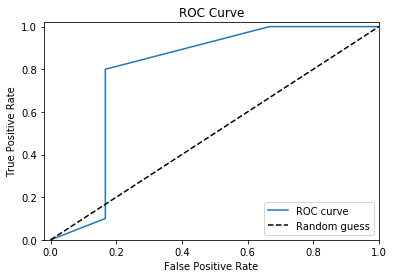

In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_prob = et.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

# Principal Component Analysis (PCA)

The explained variance ratio with 2 components is 0.99. It could produce 0.75 accuracy with Extra tree model, compare to models without PCA. One of the most important applications of PCA is for speeding up machine learning algorithms as I intent to increase the data set. 

In [12]:
# Results 3 Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  

X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

# Explained_variance Ration
explained_variance = pca.explained_variance_ratio_  

print(explained_variance[0:5])
print (np.cumsum(explained_variance[0:5]))

[0.62581597 0.37167878 0.00192235]
[0.62581597 0.99749475 0.9994171 ]


In [13]:
score_matrix = pd.DataFrame() # Instantiate the empty shell to hold the function

models = [logreg, rf,et,ada,gb, svm, xb, xb1, evc]

for i in models:
    score_matrix = score_matrix.append(model_scores(i, X_train_sc, y_train, X_test_sc, y_test))
score_matrix

,model,accuracy score,cv train score,cv test score,train score,test score,train-test gap,model status,bias vs variance
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.5000,0.638889,0.433333,1.000000,0.5000,0.500000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.3125,0.643452,0.388889,1.000000,0.3125,0.687500,overfit,high variance
0,"(ExtraTreeClassifier(class_weight=None, criter...",0.7500,0.624008,0.444444,1.000000,0.7500,0.250000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.6250,0.665476,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.6875,0.601587,0.500000,1.000000,0.6875,0.312500,overfit,high variance
0,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.4375,0.600397,0.500000,0.733333,0.4375,0.295833,overfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.6250,0.644841,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.6250,0.668651,0.566667,1.000000,0.6250,0.375000,overfit,high variance
0,"VotingClassifier(estimators=[('lr', LogisticRe...",0.5000,0.684921,0.500000,1.000000,0.5000,0.500000,overfit,high variance


In [14]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = et.predict(X_test_sc)  
cm = confusion_matrix(y_test, y_pred)  

print(cm)  
print(classification_report(y_test, y_pred))

[[5 1]
 [3 7]]
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.88      0.70      0.78        10

   micro avg       0.75      0.75      0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16



From the confusion matrix, we see that the classifier got the following results:
- Out of the (horizontal sum of 6) actual instances of 'ham' (not spam), it predicted correctly 5 of them;
- Out of the (horizontal sum of 10) total actual instances of spam, it predicted correctly 7 of them. Therefore, the chance of predicting market is up correctly is higher than that of market is down.

# Telsa Only

While building up a model on one particular company (Tesla), the accuracy and train-test gap are lowest. However, it doesn't mean that it is correctly labeled the target because there are only 4 test set. It is not representative enough for investor to risk their money on the market due to the limited dataset. 

In [15]:
import pickle
df = pickle.load(open( "../data/df_1.pkl", "rb" ))
df = df.drop(columns=['Close','Open','pct_price'])
df.drop_duplicates(subset='transcripts', keep='first', inplace=True)

df = df.select_dtypes([np.number])
len(df)

15

In [16]:
X = df.drop(columns=['pct_price_target','Volume'])
y = df['pct_price_target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train) # must fit transform to numbers for train 
X_test_sc = ss.transform(X_test)       # must transform to number for test

In [17]:
score_matrix = pd.DataFrame() # Instantiate the empty shell to hold the function

models = [rf,et,ada, xb, xb1]

for i in models:
    score_matrix = score_matrix.append(model_scores(i, X_train_sc, y_train, X_test_sc, y_test))
score_matrix

,model,accuracy score,cv train score,cv test score,train score,test score,train-test gap,model status,bias vs variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",1.00,0.444444,1.0,0.909091,1.00,-0.090909,underfit,high variance
0,"(ExtraTreeClassifier(class_weight=None, criter...",0.75,0.361111,1.0,1.000000,0.75,0.250000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",1.00,0.527778,1.0,1.000000,1.00,0.000000,underfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.00,0.444444,1.0,1.000000,1.00,0.000000,underfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.00,0.444444,1.0,1.000000,1.00,0.000000,underfit,high variance


In [18]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X_train.columns
feature_importance_df['coef'] = xb.feature_importances_
feature_importance_df.sort_values(by='coef', ascending=False).head(10)

,feature,coef
43,tx_MDcoleman_liau_index,0.494497
9,tx_MD_neg,0.159128
3,pct_volume,0.144896
2,rev_total_b,0.143217
10,tx_MD_pos,0.046582
21,tx_MD_subjectivity,0.005561
17,polarity,0.005493
51,tx_QAlinsear_write_formula,0.000550
38,tx_MDflesch_kincaid_grade,0.000075
34,tx_MD_num_syl,0.000000


In [19]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = et.predict(X_test_sc)  
cm = confusion_matrix(y_test, y_pred)  

print(cm)  
print(classification_report(y_test, y_pred))

[[3 1]
 [0 0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



## Principal Component Analysis (PCA) for Tesla

In [20]:
# Results 5 Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  

X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

# Explained_variance Ration
explained_variance = pca.explained_variance_ratio_  

print(explained_variance[0:5])
print (np.cumsum(explained_variance[0:5]))

[7.52800649e-01 2.46397280e-01 6.70685104e-04]
[0.75280065 0.99919793 0.99986861]


In [21]:
score_matrix = pd.DataFrame() # Instantiate the empty shell to hold the function

models = [rf,et,ada, xb, xb1]

for i in models:
    score_matrix = score_matrix.append(model_scores(i, X_train_pca, y_train, X_test_pca, y_test))
score_matrix

,model,accuracy score,cv train score,cv test score,train score,test score,train-test gap,model status,bias vs variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.50,0.333333,1.0,1.000000,0.50,0.500000,overfit,high variance
0,"(ExtraTreeClassifier(class_weight=None, criter...",0.75,0.361111,1.0,1.000000,0.75,0.250000,overfit,high variance
0,"(DecisionTreeClassifier(class_weight=None, cri...",0.75,0.416667,1.0,1.000000,0.75,0.250000,overfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.75,0.333333,1.0,0.727273,0.75,-0.022727,underfit,high variance
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.50,0.444444,1.0,0.818182,0.50,0.318182,overfit,high variance


In [22]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = et.predict(X_test_pca)  
cm = confusion_matrix(y_test, y_pred)  

print(cm)  
print(classification_report(y_test, y_pred))

[[3 1]
 [0 0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         0

   micro avg       0.75      0.75      0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



# Simple Neural Network

Neural Network doesn't provide any value to classify the output. It may attributed to two issues: 

1. The non-random part of the relationship between the input and output is too small compared to the random part (one could argue that stock prices are like this). I.e. the input are not sufficiently related to the output. There isn’t an universal way to detect this as it depends on the nature of the data.
2. Too much noise in the dataset as feature columns contains similar information that people are repeatedly talking in the call transcript
3. The test and training size of is too small. 

Therefore, neural network may not be the solution for this dataset

In [24]:
import pickle
df = pickle.load(open( "../data/df_final.pkl", "rb" ))
df = df.drop(columns=['Close','Open','pct_price'])
df.drop_duplicates(subset='transcripts', keep='first', inplace=True)

df = df.select_dtypes([np.number])
len(df)

61

In [25]:
X = df.drop(columns=['pct_price_target','Volume'])
y = df['pct_price_target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [26]:
from keras.models import Sequential
from keras import layers


input_dim = X_train.shape[1]
# Number of features

model = Sequential()

#hidden layers
model.add(layers.Dense(5300, input_dim=input_dim, activation='relu'))

model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))

#output layer
model.add(layers.Dense(1, activation='sigmoid'))  #Dense should be 1 for the binary output 

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = model.fit(X_train, y_train, 
         epochs=30, 
         batch_size=128, 
         validation_data=(X_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 16 samples
Epoch 1/30
45/45 [==============================] - 0s 9ms/step - loss: 8.7238 - acc: 0.4000 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 2/30
45/45 [==============================] - 0s 320us/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 3/30
45/45 [==============================] - 0s 781us/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 4/30
45/45 [==============================] - 0s 867us/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 5/30
45/45 [==============================] - 0s 560us/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 6/30
45/45 [==============================] - 0s 377us/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 7/30
45/45 [==============================] - 0s 1ms/step - loss: 6.0891 - acc: 0.6222 - val_loss: 10.0738

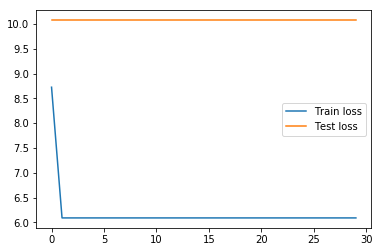

In [29]:
plt.plot(history.history['loss'], label='Train loss') #the error (loss) is getting lower
plt.plot(history.history['val_loss'], label='Test loss') #the error (loss) is getting lower
plt.legend()

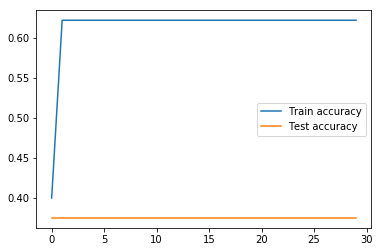

In [30]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend()